# PyTorch Neural Net

In [1]:
import os
from glob import glob
import random
import time
import pickle
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

#to import from src directory
import sys
sys.path.append('./src/')

%load_ext autoreload
%autoreload 1
%aimport main
%aimport Helper

In [2]:
# some constants

#random numbers rn
NUM_TRAIN = 9000
NUM_VAL = 1000
NUM_TEST = 10000

NUM_CLASSES = 10
IMG_W = 64
IMG_H = 64

RS = 22 # random seed

In [3]:
%autoreload

# FOR LOADING THE DATA FOR THE FIRST TIME
# COMMENT OUT ONCE PICKLE FILES ARE SAVED

#Xtrain, Ytrain = Helper.load_train(IMG_W, IMG_H)
#Xtest, test_ids = Helper.load_test(IMG_W, IMG_H)

#with open('./train_array.pkl', 'wb') as fid:
    #pickle.dump((Xtrain, Ytrain), fid) #stores a tuple
#with open('./test_array.pkl', 'wb') as fid:
    #pickle.dump(Xtest, fid)
#with open('./test_ids.pkl', 'wb') as fid:
#    pickle.dump(test_ids, fid)

In [4]:
# load in the image data from the pickle files

with open('./train_array.pkl', 'rb') as fid:
    X_train,Y_train = pickle.load(fid)
with open('./test_array.pkl', 'rb') as fid:
    Xtest = pickle.load(fid)
print("Xtrain shape:", X_train.shape)
print("Ytrain shape:", Y_train.shape)
print("Xtest shape:", Xtest.shape)

Xtrain shape: (22424, 64, 64, 3)
Ytrain shape: (22424,)
Xtest shape: (79726, 64, 64, 3)


In [5]:
# split training data into train/validation split
Xtrain, Xval, Ytrain, Yval = train_test_split(X_train, Y_train, test_size=0.30, random_state=RS)
print(Xtrain.shape, Ytrain.shape, Xval.shape, Yval.shape, sep='\n')

(15696, 64, 64, 3)
(15696,)
(6728, 64, 64, 3)
(6728,)


In [6]:
#convert arrays to torch.Tensor
Xtrain = np.transpose(Xtrain, (0, 3, 1, 2)) # transpose to match PyTorch model format
Xtrain = torch.from_numpy(Xtrain)
Ytrain = torch.from_numpy(Ytrain)

Xval = np.transpose(Xval, (0, 3, 1, 2))
Xval = torch.from_numpy(Xval)
Yval = torch.from_numpy(Yval)

Xtest = np.transpose(Xtest, (0, 3, 1, 2))
Xtest = torch.from_numpy(Xtest)
#Ytest = np.transpose(Ytest, (0, 3, 1, 2))


# Data Exploration

(22424, 3)


<Figure size 1440x1440 with 0 Axes>

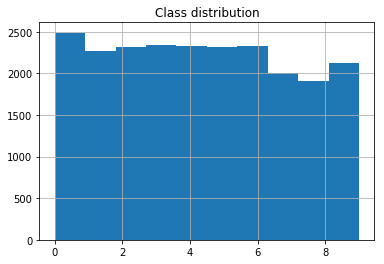

In [7]:
dataset = pd.read_csv('data/driver_imgs_list.csv')
print(dataset.shape)

# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=1, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

# Creating Model

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import timeit

In [9]:
torch.cuda.is_available()

False

In [10]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.reshape(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [11]:
if torch.cuda.is_available():
    DTYPE = torch.cuda.FloatTensor #GPU type
else:
    DTYPE = torch.FloatTensor #CPU type

In [12]:
model_base = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=10, stride=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, stride=2),
    nn.Dropout(0.5),
    Flatten(),
    nn.Linear(46656,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 10),
)

model = model_base.type(DTYPE)

loss_fn = nn.CrossEntropyLoss().type(DTYPE)
optimizer = optim.SGD(model.parameters(), lr = 1e-4, weight_decay = 0.9, momentum=0.8)
#decayRate = 0.96
#optimizer = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate) # wrap optimizer in a learning rate decay

# Training model

In [13]:
%autoreload
import time
start_time = time.time()

torch.cuda.random.manual_seed(2468)
model.apply(Helper.reset)
loss_history = Helper.train(model, Xtrain, Ytrain, loss_fn, optimizer, num_epochs=3, dtype = DTYPE)

print("--- %s seconds to train ---" % (time.time() - start_time)) # print the training time

Starting epoch 1 / 3
t = 25, loss = 2.3577
t = 50, loss = 2.1237
t = 75, loss = 2.0493
t = 100, loss = 1.9149
t = 125, loss = 1.9736
t = 150, loss = 1.8845
t = 175, loss = 1.7178
t = 200, loss = 1.7452
t = 225, loss = 1.5076
t = 250, loss = 1.5176
t = 275, loss = 1.7100
t = 300, loss = 1.2585
Starting epoch 2 / 3
t = 25, loss = 1.4667
t = 50, loss = 1.4199
t = 75, loss = 1.2405
t = 100, loss = 1.3306
t = 125, loss = 1.3032
t = 150, loss = 1.2782
t = 175, loss = 1.2561
t = 200, loss = 1.2062
t = 225, loss = 1.1697
t = 250, loss = 1.2419
t = 275, loss = 1.3156
t = 300, loss = 1.0198
Starting epoch 3 / 3
t = 25, loss = 1.0399
t = 50, loss = 1.0704
t = 75, loss = 0.9478
t = 100, loss = 1.1092
t = 125, loss = 1.1062
t = 150, loss = 1.0517
t = 175, loss = 1.0289
t = 200, loss = 1.0630
t = 225, loss = 1.0206
t = 250, loss = 0.9764
t = 275, loss = 1.1155
t = 300, loss = 0.8369
--- 663.0913126468658 seconds to train ---


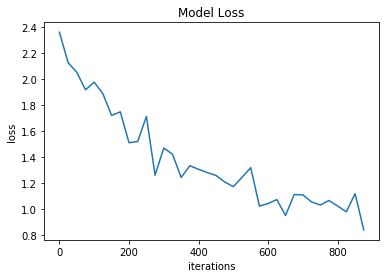

In [14]:
plt.plot(np.arange(0, len(loss_history)*25, 25), loss_history)
plt.title("Model Loss")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.show()

In [15]:
print(min(loss_history))

0.8368687629699707


# Evaluating model

In [16]:
%autoreload

Helper.evaluate(model, Xval, Yval, Xval.shape[0], DTYPE)
Helper.multiclass_log_loss(model, Xval, Yval, Xval.shape[0], DTYPE)

Got 5961 / 6700 correct (88.97)
tensor(0.8790)


tensor(0.8790)

In [17]:

matrix = Helper.confusion_matrix(model, Xval, Yval, Xval.shape[0], DTYPE)
# x axis = actual value
# y axis = predicted value

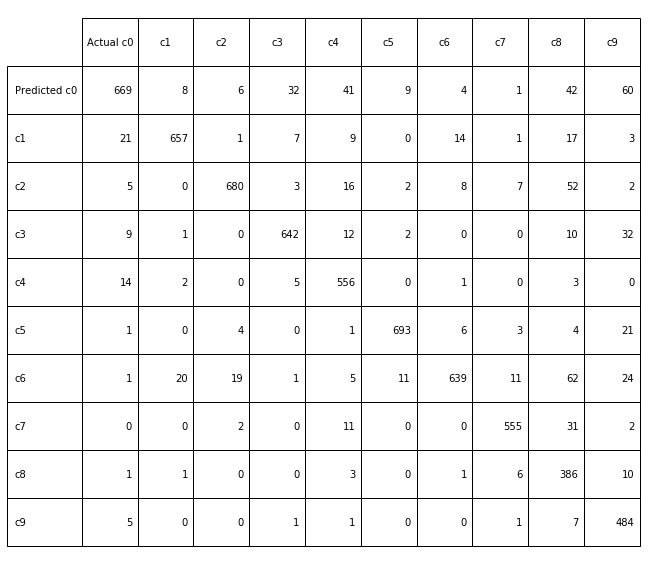

In [19]:
%autoreload
fig, axs = plt.subplots(figsize = (10, 10))
axs.axis('tight')
axs.axis('off')

rows = ['Actual c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
cols = rows.copy()
cols[0] = 'Predicted c0'


df = pd.DataFrame(np.array(matrix), columns=rows, index=cols)
table = axs.table(cellText=df.values, colLabels = df.columns, rowLabels = df.index,  loc='center')
table.scale(1, 4)



In [ ]:
#parameter tuning
%autoreload

#results = {}
#best_val = -1
#best_softmax = None
#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [2.5e4, 5e4]



#torch.cuda.random.manual_seed(2468)
#model.apply(Helper.reset)
#loss_history = Helper.train(model, Xtrain, Ytrain, loss_fn, optimizer, num_epochs=3, dtype = DTYPE)

In [ ]:
# run on the test set for final accuracy
%autoreload
predictions = Helper.get_predictions(model, Xtest, Xtest.shape[0], DTYPE)

#predictions = Helper.get_predictions(model, Xtest[:101], 101, DTYPE)

In [ ]:
print(len(predictions))

In [ ]:
%autoreload

#bring in the test_ids (image filenames in test directory)
with open('./test_ids.pkl', 'rb') as fid:
    test_ids = pickle.load(fid)

#setup predictions array for kaggle submission
predictions_matrix = Helper.to_prediction_list(predictions)

In [ ]:
print(predictions_matrix[0])

In [ ]:
# make a kaggle submission
#print(predictions_matrix.shape)
Helper.create_submission(predictions_matrix, test_ids)

# Kaggle will provide the test accuracy result

In [ ]:
# save the best model to a pickle file
#with open(torch_model.pkl) as fid:
#    pickle.dump(model, fid)